In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [2]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy
from pympler import asizeof

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch, omnisketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)
reload(omnisketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates, MaterializedCombinations, get_n_updates_customized

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib.omnisketch import DieHash, DistinctSample, Kmin, CountMin, CountMinDyad, sorted_intersection

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches, compute_relative_entropy

# set_style()

/home/rudi/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [3]:
# Test DieHash functionality
m = 8  # number of levels
seed = 42
die_hash = DieHash(m, seed=seed)

# Test hash values for a range of ids
test_ids = list(range(10))
hash_levels = [die_hash.hash(i) for i in test_ids]

print("Test ids:", test_ids)
print("Hash levels:", hash_levels)

# Check that all levels are within [0, m-1]
assert all(0 <= level < m for level in hash_levels), "Hash levels out of bounds"
print("All hash levels are within expected range.")

Test ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Hash levels: [0, 0, 2, 1, 0, 0, 4, 1, 1, 0]
All hash levels are within expected range.


In [ ]:
# Test DistinctSample functionality

# Create a DistinctSample instance
ds = DistinctSample(die_hash, max_sample_size=5, max_level=m)

# Add test_ids to the sample
for id_ in test_ids:
    ds.add(id_)

print("Sample after adding test_ids:", ds.sample)
print("Current sample size:", ds.cur_sample_size)
print("Sample level:", ds.sample_level)

# Check that sample size does not exceed max_sample_size
assert ds.cur_sample_size <= ds.max_sample_size, "Sample size exceeds max_sample_size"

# Test reset functionality
ds.reset()
print("Sample after reset:", ds.sample)
print("Current sample size after reset:", ds.cur_sample_size)
assert ds.cur_sample_size == 0, "Sample size should be 0 after reset"

Sample after adding test_ids: {2: {2}, 1: {8, 3, 7}, 4: {6}}
Current sample size: 5
Sample level: 1
Sample after reset: {}
Current sample size after reset: 0


In [ ]:
# Test Kmin functionality

# Initialize Kmin instance
kmin = Kmin(max_sample_size=5, b=16, repetition=0)

# Add test_ids to the Kmin sketch using their hashes
for id_ in test_ids:
    hx = kmin.hash(id_)
    kmin.add(hx)

print("Kmin sketch (heap, negative values):", kmin.sketch)
print("Current sample size:", kmin.cur_sample_size)
print("Current tree root (max hash in sketch):", kmin.cur_tree_root)

# Check that sample size does not exceed max_sample_size
assert kmin.cur_sample_size <= kmin.k, "Sample size exceeds max_sample_size"

# Test reset functionality
kmin.reset()
print("Kmin sketch after reset:", kmin.sketch)
print("Current sample size after reset:", kmin.cur_sample_size)
assert kmin.cur_sample_size == 0, "Sample size should be 0 after reset"

Kmin sketch (heap, negative values): [-30939, -29714, -7412, -10560, -17611]
Current sample size: 5
Current tree root (max hash in sketch): 30939
Kmin sketch after reset: []
Current sample size after reset: 0


In [9]:
# Test CountMin functionality

# Prepare DieHash functions for CountMin
num_hashes = 3
die_hash_functions = [DieHash(m, seed=seed + i) for i in range(num_hashes)]

# Initialize CountMin instance
attr = 1
width = 5
depth = num_hashes
cm = CountMin(die_hash_functions, attr, width=width, depth=depth)

# Add test_ids to the CountMin sketch using their hashes
for id_ in test_ids:
    hx = die_hash.hash(id_)
    cm.add(id_, attr_value=id_, hx=hx)

# Query the sketch for a specific attribute value
query_result = cm.query(attr_value=5)
print("Query result for attr_value=5:", query_result)

# Check that the returned objects are of expected type
for obj in query_result:
    assert isinstance(obj, (DistinctSample, Kmin)), "Unexpected object type in CountMin sketch"

# Test reset functionality
cm.reset()
print("CountMin sketch reset. Query after reset:", cm.query(attr_value=5))

Query result for attr_value=5: [Kmin(k=10000, delta=0.05, cur_sample_size=2, cur_tree_root=4, n=2), Kmin(k=10000, delta=0.05, cur_sample_size=3, cur_tree_root=1, n=3), Kmin(k=10000, delta=0.05, cur_sample_size=2, cur_tree_root=0, n=2)]
CountMin sketch reset. Query after reset: [Empty Kmin(k={self.k}, delta={self.delta}), Empty Kmin(k={self.k}, delta={self.delta}), Empty Kmin(k={self.k}, delta={self.delta})]


In [16]:
# Test CountMinDyad functionality

# Parameters for CountMinDyad
interval_size = 8
dyad_width = 4
dyad_depth = 3
delta_ds = 0.05
dyadic_range_bits = 16
repetition = 0

# Initialize CountMinDyad instance
countmin_dyad = CountMinDyad(
    attr=attr,
    interval_size=interval_size,
    width=dyad_width,
    depth=dyad_depth,
    delta_ds=delta_ds,
    dyadic_range_bits=dyadic_range_bits,
    repetition=repetition
)

# Add test_ids to the CountMinDyad sketch
for id_ in test_ids:
    lower = id_
    higher = id_ + 1
    hx = die_hash.hash(id_)
    countmin_dyad.add(lower, higher, hx)

print("Added test_ids to CountMinDyad.")

# Query a range in the sketch
seen_n = [0] * dyad_depth
query_lower = 2
query_higher = 5
range_result = countmin_dyad.range_query(query_lower, query_higher, seen_n)

print(f"Range query result for [{query_lower}, {query_higher}]:", range_result)
print("Seen_n after query:", seen_n)

# Test reset functionality
countmin_dyad.reset()
print("CountMinDyad reset. Range query after reset:", countmin_dyad.range_query(query_lower, query_higher, [0] * dyad_depth))

Added test_ids to CountMinDyad.
Range query result for [2, 5]: [{1, 4}, {0}, {0, 1}]
Seen_n after query: [2, 2, 3]
CountMinDyad reset. Range query after reset: [set(), set(), set()]


In [ ]:
import math
import copy
from typing import List, Any

class OmniSketch:

    cmsketches: List[CountMin]
    cmsketches_range: List[List[CountMinDyad]]

    def __init__(self, num_attributes, cat_col_map, num_col_map, depth, width,
                 delta=0.1, eps = 0.1, max_sample_size=10_000, 
                 dyadic_range_bits=16, max_level=32):
        self.depth = depth
        self.width = width
        self.max_sample_size = max_sample_size
        self.num_attributes = num_attributes
        self.dyadic_range_bits = dyadic_range_bits
        self.max_level = max_level


        self.cat_col_map = cat_col_map
        self.num_col_map = num_col_map
        
        self.delta = delta
        self.eps = eps

        self.die_hash_functions = []
        for i in range(self.depth):
            self.die_hash_functions.append(DieHash(self.max_level))

        self.cmsketches = [None] * len(cat_col_map)
        for i in range(len(cat_col_map)):
            self.cmsketches[i] = CountMin(self.die_hash_functions, i, width=width, depth=depth)

        self.cmsketches_range = [[None for _ in range(self.dyadic_range_bits + 1)] for _ in range(len(num_col_map))]
        for i in range(len(num_col_map)):
            for j in range(self.dyadic_range_bits, -1, -1):
                self.cmsketches_range[i][self.dyadic_range_bits - j] = CountMinDyad(attr=i, interval_size=j, 
                                                                                  width=width, depth=depth,
                                                                                  delta_ds=delta, 
                                                                                  dyadic_range_bits=dyadic_range_bits)
        # Check parameters
        self.kmin_tmp = Kmin()
        
    def update(self, id_, element: tuple):
        hx = self.kmin_tmp.hash(id_)
        element : np.ndarray = np.asarray(element)
        cat_values = element[self.cat_col_map]
        num_values = element[self.num_col_map].astype(int)

        for i in range(len(self.cat_col_map)):  
            self.cmsketches[i].add(id_, cat_values[i], hx)

        for i in range(len(self.num_col_map)):
            ranges = self.wrapper_init_log_ranges(num_values[i])
            for j in range(len(ranges[2])):
                self.cmsketches_range[i][j].add(ranges[1][j], ranges[2][j], hx)

    def wrapper_init_log_ranges(self, l):
        if l < 0:
            print("Error: l < 0")
            raise ValueError("Log range cannot be negative")
        ranges = self.get_log_ranges(l + 1)
        for i in range(len(ranges[2])):
            ranges[1][i] -= 1
            ranges[2][i] -= 1
        return ranges

    def get_log_ranges(self, input_key):
        coeff = [0] * self.dyadic_range_bits
        lower_bound = [0] * self.dyadic_range_bits
        upper_bound = [0] * self.dyadic_range_bits

        half_point = int(math.pow(2, self.dyadic_range_bits - 1))
        if input_key < half_point:
            coeff[0] = 0
            lower_bound[0] = 1
            upper_bound[0] = half_point
        else:
            coeff[0] = 1
            lower_bound[0] = half_point
            upper_bound[0] = half_point * 2

        pow_ = half_point
        for i in range(1, self.dyadic_range_bits - 1):
            prev_coeff = coeff[i - 1]
            new_coeff_lower = prev_coeff * 2
            pow_ //= 2
            if (new_coeff_lower + 1) * pow_ < input_key:
                new_coeff_lower += 1
                coeff[i] = new_coeff_lower
            else:
                coeff[i] = new_coeff_lower
            lower_bound[i] = coeff[i] * pow_ + 1
            upper_bound[i] = (coeff[i] + 1) * pow_
        lower_bound[self.dyadic_range_bits - 1] = input_key
        upper_bound[self.dyadic_range_bits - 1] = input_key
        coeff[self.dyadic_range_bits - 1] = input_key

        return [coeff, lower_bound, upper_bound]

    def query(self, query: List[Any]):
        cat_predicates = [query[i] for i in self.cat_col_map]
        # num_predicates = [query[i] for i in self.num_col_map]

        s_cap = 0
        n_max = 0
        samples = [] #[None] * len(cat_predicates)
        
        n_predicates = 0
        for i in range(len(cat_predicates)):
            if cat_predicates[i] != '*':
                n_predicates += 1
                temp = self.cmsketches[i].query(cat_predicates[i])
                samples.append(temp)
        n_max = self.get_nmax(samples)
        s_cap = sorted_intersection(samples)

        # Based on the formulas in the paper n_max is missing in the numerator and max_sample_size 
        # is missing in the denominator. This formula only works if n_max == max_sample_size
        constraint = 3 * math.log((4 * n_predicates * self.depth * math.sqrt(self.max_sample_size)) / self.delta) / (self.eps * self.eps)
        case2_estimate = math.ceil(s_cap * n_max / self.max_sample_size)

        intersect_size = s_cap
        if s_cap < constraint:
            return int(math.ceil(2 * n_max * math.log((4 * n_predicates * self.depth * math.sqrt(self.max_sample_size)) / self.delta) / (self.max_sample_size * self.eps * self.eps)))
        else:
            # q.thrm33_case2 = True
            return int(math.ceil(s_cap * n_max / self.max_sample_size))

    def get_nmax(self, samples: List[Kmin]):
        n_max = 0
        for sample in samples:
            if sample.n > n_max:
                n_max = sample.n
        return n_max

    def range_query(self, query, q):
        num_predicates = [query[i] for i in self.num_col_map]
        s_cap = 0
        n_max = 0
        b_virtual = 0
        samples = []
        ns = np.zeros((self.num_attributes, self.depth), dtype=int)

        b_virtual = 0
        num_predicates = 0
        for i in range(len(num_predicates)):
            if num_predicates[i] == '*':
                continue
            num_predicates += 1
            attr = self.num_col_map[i]
            lower = num_predicates[i][0]
            upper = num_predicates[i][1]

            ranges_list = self.wrap_log_ranges(lower, upper)
            samples : List[Kmin] = [None] * self.depth
            # b_virtual does not make sense here, because gets updated in the loop
            b_virtual = len(ranges_list) * self.max_sample_size
            for j in range(len(ranges_list)):
                cm: CountMinDyad = self.cmsketches_range[attr][self.get_index_of_range(ranges_list[j])]
                range_samples = cm.range_query(ranges_list[j][0], ranges_list[j][1])        
                for d in range(self.depth):
                    if samples[d] is None:
                        samples[d] = range_samples[d]
                    else:
                        samples[d] = samples[d].merge_samples(range_samples[d])
                    ns[attr, d] += range_samples[d].n

        n_max = np.max(ns)
        s_cap = sorted_intersection(samples)
        constraint = 3 * math.log((4 * num_predicates * self.depth * math.sqrt(b_virtual)) / self.delta) / (self.eps * self.eps)
        case2_estimate = math.ceil(s_cap * n_max / b_virtual)

        if s_cap < constraint:
            return int(math.ceil(2 * n_max * math.log((4 * num_predicates * self.depth * math.sqrt(b_virtual)) / self.delta) / (b_virtual * self.eps * self.eps)))
        else:
            return int(math.ceil(s_cap * n_max / b_virtual))

    def wrap_log_ranges(self, low, up):
        if low < 0 or up < 0:
            print(f"Error because low or up < 0: low: {low} up: {up}")
            exit(1)
        temp = self.get_log_ranges_arr_list(low + 1, up + 1, self.dyadic_range_bits)
        for i in temp:
            i[0] -= 1
            i[1] -= 1
        return temp

    # They call index, what we call level
    @staticmethod
    def get_index_of_range(longs):
        return int(math.log(longs[1] - longs[0] + 1) / math.log(2))

    # Minimal dyadic range cover.
    @staticmethod
    def get_log_ranges_arr_list(start_inclusive, stop_inclusive, dyadic_range_bits=16):
        start_inclusive -= 1
        stop_inclusive -= 1
        init_diff = stop_inclusive - start_inclusive + 1
        result = []
        total_sum = 0
        pow_ = 1
        for j in range(dyadic_range_bits):
            if start_inclusive + pow_ - 1 > stop_inclusive:
                break
            elif start_inclusive % (pow_ * 2) == 0 and start_inclusive + pow_ - 1 <= stop_inclusive:
                pass
            else:
                result.append([1 + start_inclusive, 1 + start_inclusive + pow_ - 1])
                total_sum += pow_
                start_inclusive += pow_
            pow_ *= 2

        pow_ = int(math.pow(2, dyadic_range_bits))
        for j in range(dyadic_range_bits, -1, -1):
            if start_inclusive % pow_ == 0 and start_inclusive + pow_ - 1 <= stop_inclusive:
                result.append([1 + start_inclusive, 1 + start_inclusive + pow_ - 1])
                total_sum += pow_
                start_inclusive += pow_
            pow_ //= 2

        if total_sum != init_diff:
            print("Error - no full coverage")
        return result

    def reset(self):
        for i in range(self.num_attributes):
            if self.has_predicate[i]:
                if self.range_queries:
                    for j in range(self.dyadic_range_bits + 1):
                        self.cmsketches_range[i][j].reset()
                else:
                    self.cmsketches[i].reset()

    @staticmethod
    def build_from_error_guarantees(num_attributes, cat_col_map, num_col_map, delta, eps):
        pass


In [ ]:
import math

def compute_max_B(mem_budget, w, d, n_cat, n_num, dyadic_levels, delta):
    """
    Find the maximum integer B such that:
    mem_budget >= w * d * |A| * (32 + B * ceil(log(4 * B**2.5 / delta)) + 3*32 + 1)
    """
    factor = w * d * (n_cat + n_num * dyadic_levels)
    left, right = 1, 10**8
    max_B = 0
    while left <= right:
        B = (left + right) // 2
        ceil_log = math.ceil(math.log(4 * (B ** 2.5) / delta))
        rhs = factor * (32 + B * ceil_log + 3 * 32 + 1)
        if rhs <= mem_budget:
            max_B = B
            left = B + 1
        else:
            right = B - 1
    print(f"Maximum B found: {max_B}, bits: {ceil_log}, rhs: {rhs}, Difference: {mem_budget - rhs}")
    return max_B


In [ ]:
delta = 0.05
eps = 0.0005
# Example usage:
# Replace these values with your known variables
mem_budget = 512*1024*1024*8  # example value for M
d = math.ceil(math.log(2/delta))         # example value for d
w = 1+math.ceil(math.e * ((eps+1)/eps)**(1/d))        # example value for w

n_cat = 5
n_num = 5
dyadic_levels = 16  # example value for dyadic_levels

print(f"w = {w}")
print(f"d = {d}")
A = 10        # example value for |A|

result_B = compute_max_B(mem_budget, w, d, n_cat, n_num, dyadic_levels, delta)
print(f"The maximum B that satisfies the inequality is: {result_B}")

w = 20
d = 4
Maximum B found: 21049, bits: 30, rhs: 4295077200, Difference: -109904
The maximum B that satisfies the inequality is: 21049


In [110]:
def compute_pacha_sketch_parameters(mem_budget, levels, cat_updates, num_updates, region_updates, num_elements=None, 
                                    eps = 0.0005, delta = 0.05, p = 0.125):

    mem_cms = mem_budget * 0.25 / levels
    n_counters = mem_cms * 1024 * 1024 / 4
    depth = 3
    width = n_counters // depth
    error_eps = np.e/width
    while error_eps < eps / region_updates and depth < 5:
        depth += 1
        width = n_counters // depth
        error_eps = np.e/width

    # TODO: Check if delta is correct
    if error_eps < eps / region_updates:
        error_eps = eps / region_updates
        cms_params = CMParameters(delta=delta, error_eps=error_eps)
    else:
        cms_params = CMParameters(width=int(width), depth=int(depth))
    
    w, d = cms_params.peek_size()
    print(f"Memory for CMSs: {mem_cms} MB")
    print(f"CMS Parameters: w={w}, d={d}, eps={np.e/w*region_updates:.4f}, delta={1/(np.e**d):.4f}")
    mem_cms = cms_params.peek_memory() * levels
    mem_index = mem_budget - mem_cms

    if cat_updates == 0:
        
        ratio_num_index = num_updates / (num_updates + region_updates)
        ratio_region_index = 1.0 - ratio_num_index
        print("Categorical index as Bitmap")
        mem_cat_index = 0
        mem_num_index = mem_index * ratio_num_index
        print(f"Memory for num index: {mem_num_index} MB")
        mem_region_index = mem_index * ratio_region_index
        print(f"Memory for region index: {mem_region_index} MB")

        n_bits_num_index = int(np.ceil(mem_num_index * 8 * 1024 * 1024))
        n_bits_region_index = int(np.ceil(mem_region_index * 8 * 1024 * 1024))

        if num_elements is None:
            k = - np.log(p) / np.log(2)
            k_num_index = k
            k_region_index = k

            print(f"Target false positive rate: {p:.4f} with k={k}")
            max_elements_num = (n_bits_num_index / k * np.log(2)) / num_updates
            max_elements_region = (n_bits_region_index / k * np.log(2)) / region_updates
            print(f"Max elements for num index: {max_elements_num}")
            print(f"Max elements for region index: {max_elements_region}")
        else:
            k_num_index = int(np.ceil((n_bits_num_index / (num_elements*num_updates)) * math.log(2)))
            k_region_index = int(np.ceil((n_bits_region_index / (num_elements*region_updates)) * math.log(2)))

            if k_num_index > 7:
                k_num_index = 7
            if k_region_index > 7:
                k_region_index = 7

            p_num_index = (1-np.e**(-k_num_index*(num_elements*num_updates)/n_bits_num_index))**k_num_index
            p_region_index = (1-np.e**(-k_region_index*(num_elements*region_updates)/n_bits_region_index))**k_region_index 

            print(f"False positve rate for num index: {p_num_index:.4f} with k={k_num_index}")
            print(f"False positve rate for region index: {p_region_index:.4f} with k={k_region_index}")

        cat_params = None
    else:
        total_updates = (cat_updates + num_updates + region_updates)
        ratio_cat_index = cat_updates / total_updates
        ratio_num_index = num_updates / total_updates
        ratio_region_index = 1.0 - ratio_cat_index - ratio_num_index
        mem_cat_index = mem_index * ratio_cat_index
        print(f"Memory for cat index: {mem_cat_index} MB")
        mem_num_index = mem_index * ratio_num_index
        print(f"Memory for num index: {mem_num_index} MB")
        mem_region_index = mem_index * ratio_region_index
        print(f"Memory for region index: {mem_region_index} MB")
        n_bits_cat_index = int(np.ceil(mem_cat_index * 8 * 1024 * 1024))
        n_bits_num_index = int(np.ceil(mem_num_index * 8 * 1024 * 1024))
        n_bits_region_index = int(np.ceil(mem_region_index * 8 * 1024 * 1024))

        if num_elements is None:
            k = - np.log(p) / np.log(2)
            k_cat_index = k
            k_num_index = k
            k_region_index = k

            print(f"Target false positive rate: {p:.4f} with k={k}")
            max_elements_cat = (n_bits_cat_index / k * np.log(2)) / cat_updates
            max_elements_num = (n_bits_num_index / k * np.log(2)) / num_updates
            max_elements_region = (n_bits_region_index / k * np.log(2)) / region_updates
            print(f"Max elements for cat index: {max_elements_cat}")
            print(f"Max elements for num index: {max_elements_num}")
            print(f"Max elements for region index: {max_elements_region}")

        else:
            k_cat_index = int(np.ceil((n_bits_cat_index / (num_elements*cat_updates))* math.log(2)))
            k_num_index = int(np.ceil((n_bits_num_index / (num_elements*num_updates)) * math.log(2)))
            k_region_index = int(np.ceil((n_bits_region_index / (num_elements*region_updates)) * math.log(2)))

            if k_cat_index > 7:
                k_cat_index = 7
            if k_num_index > 7:
                k_num_index = 7
            if k_region_index > 7:
                k_region_index = 7

            p_cat_index = (1-np.e**(-k_cat_index*(num_elements*cat_updates)/n_bits_cat_index))**k_cat_index
            p_num_index = (1-np.e**(-k_num_index*(num_elements*num_updates)/n_bits_num_index))**k_num_index
            p_region_index = (1-np.e**(-k_region_index*(num_elements*region_updates)/n_bits_region_index))**k_region_index

            print(f"False positve rate for cat index: {p_cat_index:.4f} with k={k_cat_index}")
            print(f"False positve rate for num index: {p_num_index:.4f} with k={k_num_index}")
            print(f"False positve rate for region index: {p_region_index:.4f} with k={k_region_index}")
        
        cat_params = BFParameters(size=n_bits_cat_index, hash_count=k_cat_index)

    num_params = BFParameters(size=n_bits_num_index, hash_count=k_num_index)
    region_params = BFParameters(size=n_bits_region_index, hash_count=k_region_index)

    return {
        "cms_params": cms_params,
        "cat_params": cat_params,
        "num_params": num_params,
        "region_params": region_params
    }

In [111]:
levels = 5
ad_tree_levels = 5
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

mem_budget = 512 # 512 MB

# pacha_params = compute_pacha_sketch_parameters(mem_budget, levels, 0, num_updates_tpch, region_updates_tpch, num_elements=3_000_000)
pacha_params = compute_pacha_sketch_parameters(mem_budget, levels, 0, num_updates_tpch, region_updates_tpch)
    

Memory for CMSs: 25.6 MB
CMS Parameters: w=1677721, d=4, eps=0.0005, delta=0.0183
Categorical index as Bitmap
Memory for num index: 64.00000762939453 MB
Memory for region index: 320.00003814697266 MB
Target false positive rate: 0.1250 with k=3.0
Max elements for num index: 1879447.4916104346
Max elements for region index: 1879447.4916104346


(4, 1342826.5744856815)

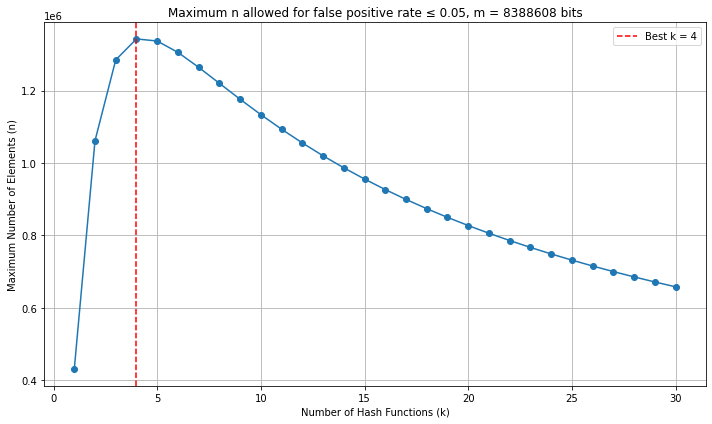

In [76]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Parameters
m = 1 * 1024 * 1024 * 8  # total bits in Bloom filter
p_target = 0.05  # desired false positive rate

def false_positive_rate(n, m, k):
    return (1 - np.exp(-k * n / m)) ** k

# Function to find the maximum n such that f(n) <= p_target for given k
def max_n_for_k(k, m, p_target):
    # Define the function f(n) - p_target = 0
    def func(n):
        return false_positive_rate(n, m, k) - p_target
    
    # Search for root in a reasonable range
    result = root_scalar(func, bracket=[1, 10 * m], method='brentq')
    if result.converged:
        return result.root
    else:
        return None

# Try different values of k
k_values = range(1, 31)
n_values = []

for k in k_values:
    n = max_n_for_k(k, m, p_target)
    n_values.append(n)

# Find best k
best_index = np.argmax(n_values)
best_k = k_values[best_index]
best_n = n_values[best_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, n_values, marker='o')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.title(f'Maximum n allowed for false positive rate ≤ {p_target}, m = {m} bits')
plt.xlabel('Number of Hash Functions (k)')
plt.ylabel('Maximum Number of Elements (n)')
plt.grid(True)
plt.legend()
plt.tight_layout()

(best_k, best_n)


In [77]:
m/best_k * np.log(2)

1453634.9960056504

In [ ]:
"SNMP" "1"

In [6]:
from sortedcontainers import SortedSet

s1 = SortedSet([1, 2, 3, 4, 10])
s2 = SortedSet([2, 3, 5, 6, 10])
s3 = SortedSet([0, 2, 3, 8, 10])

intersection = sorted_intersection([s1, s2, s3])
print(intersection)  # Output: [2, 3, 10]


3


In [8]:
s1

SortedSet([1, 2, 3, 4, 10])

In [7]:
# s.pop()  
s1.union(s2)

SortedSet([1, 2, 3, 4, 5, 6, 10])

In [19]:
OmniSketch.get_log_ranges_arr_list(1,8, 5)

[[1, 8]]

# EXTRA

In [ ]:
import random


class CountMin:
    def __init__(self, die_hash_functions, attr, eps=0.005, delta_cm=0.05, delta_ds=0.05):
        
        self.delta_cm = delta_cm
        self.delta_ds = delta_ds
        self.eps = eps
        self.depth = int(math.ceil(math.log(1 / self.delta_cm) / math.log(math.exp(1))))
        eps_cm_pow_d = eps / (1 + eps)
        self.eps_cm = eps_cm_pow_d ** (1.0 / self.depth)
        self.eps_ds = eps ** self.depth
        self.width = 1 + int(math.ceil(math.exp(1) / eps_cm))

        self.die_hash_functions = die_hash_functions  # list of DieHash
        self.attr = attr
        self.rng = random.Random()
        self.cm = [[None for _ in range(main.width)] for _ in range(main.depth)]
        self.init_sketch()

    def init_sketch(self):
        for j in range(main.depth):
            for i in range(main.width):
                if main.use_ds:
                    self.cm[j][i] = DistinctSample(self.die_hash_functions[j])
                else:
                    self.cm[j][i] = Kmin(main.delta_ds)

    def hash(self, attr_value: int, depth: int, width: int) -> list[int]:
        self.rng.seed(attr_value + main.repetition)
        return [self.rng.randint(0, width - 1) for _ in range(depth)]

    def add(self, id_: int, attr_value: int, hx: int):
        hashes = self.hash(attr_value, main.depth, main.width)
        for j in range(main.depth):
            w = hashes[j]
            self.cm[j][w].add(hx)

    def query(self, attr_value: int) -> list:
        hashes = self.hash(attr_value, main.depth, main.width)
        if main.use_ds:
            result = [None] * main.depth  # type: list[DistinctSample]
        else:
            result = [None] * main.depth  # type: list[Kmin]
        for j in range(main.depth):
            w = hashes[j]
            result[j] = self.cm[j][w]
        return result

    def reset(self):
        for j in range(main.depth):
            for i in range(main.width):
                self.cm[j][i].reset()


In [ ]:
def get_size_sketch(ram, eps, num_attrs, q_target, use_ds):
    delta_cm = 0.05
    delta_ds = 0.05
    depth = int(math.ceil(math.log(1 / delta_cm) / math.log(math.exp(1))))
    eps_cm_pow_d = eps / (1 + eps)
    eps_cm = eps_cm_pow_d ** (1.0 / depth)
    eps_ds = eps ** depth
    width = 1 + int(math.ceil(math.exp(1) / eps_cm))
    ratio = 1 / q_target

    if use_ds:
        numerator = math.log(1 / delta_ds) / math.log(math.exp(1))
        denominator = eps_ds ** 2
        B = int(math.ceil(12 * (numerator / denominator) * ratio))
        mem_usage = depth * width * B * num_attrs * 4
    else:
        numerator = math.log(2 * num_attrs * depth / delta_ds) / math.log(math.exp(1))
        denominator = eps_ds ** 2
        B = int(math.ceil(2 * (numerator / denominator) * ratio))
        b = int(math.ceil(math.log(4 * (B ** (5 / 2)) / delta_ds)))
        mem_usage = int(depth * width * ((B * b + 3 * 32 + 1) + 32) * num_attrs)

    if mem_usage < ram:
        info = [mem_usage, depth, width, B, eps, eps_cm, eps]
    else:
        info = [0.0] * 7
    return info